## Phase 1

#Accomplishments:

-EDA on station that we want to predict the temperature on (KPHL), plus four other surrounding stations (KABE, KACY, KLNS, KTTN); all 4 current variables are graphed.

-Successfully created a random forest model to identify the window size (in LSTM model) and found that the next hour's temperature can mostly be predicted by the two previous hour's temperature data. Thus, our window size will be 2-4 hours.
    

#Challenges:

-Determining the window size; intially we were using the previous 24hours data.

#Next Steps:

-Combine the four surrounding stations into our model to increase its accuracy

## Goal station : Philadelphia (red)
## 4 stations that we chose : 1. Allentown 2. Lancaster 3. Trenton 4. Atlanta City (black)

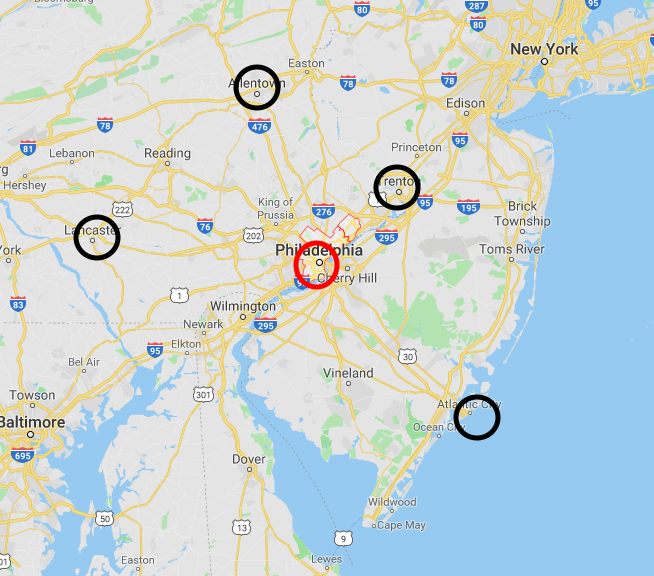

In [24]:
from IPython.display import Image
Image("./pic.png")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


#Stacked auto encoder
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector


#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=1)

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

os.environ["KMP_DUPLICATE_LIB_OK"]="True"



Using TensorFlow backend.


In [2]:
def process_FAA_hourly_data(filename):
    path = os.getcwd()
    pathfile = os.path.join(path,"data",filename)
    df_temps = pd.read_csv(pathfile, skiprows=16)
    df_temps = df_temps.iloc[:,:-1]
    df_temps = df_temps.loc[df_temps[df_temps.columns[0]] != df_temps.columns[0]]
    df_temps[df_temps.columns[1]] = df_temps[df_temps.columns[1]].apply(pd.to_numeric, downcast = "integer")
    df_temps[df_temps.columns[2:]] = df_temps[df_temps.columns[2:]].apply(pd.to_numeric, downcast = "float")
    df_temps = df_temps.set_index(pd.DatetimeIndex(df_temps[df_temps.columns[0]]))
    df_temps = df_temps.drop([df_temps.columns[0]], axis=1)
    return df_temps

## Import all the files from 5 stations

In [3]:
df_kphl = process_FAA_hourly_data("faa_hourly-KPHL_20120101-20190101.csv")
df_kabe = process_FAA_hourly_data("faa_hourly-KABE_20120101-20190101.csv")
df_kacy = process_FAA_hourly_data("faa_hourly-KACY_20120101-20190101.csv")
df_klns = process_FAA_hourly_data("faa_hourly-KLNS_20120101-20190101.csv")
df_kttn = process_FAA_hourly_data("faa_hourly-KTTN_20120101-20190101.csv")

Extract Average Temp, Average Relative Humidity,	Average Wind Speed, Average Station Pressure

In [4]:
df_kphl_useful = df_kphl.iloc[:,[1,7,8,9]]
df_kabe_useful = df_kabe.iloc[:,[1,7,8,9]]
df_kacy_useful = df_kacy.iloc[:,[1,7,8,9]]
df_klns_useful = df_klns.iloc[:,[1,7,8,9]]
df_kttn_useful = df_kttn.iloc[:,[1,7,8,9]]

In [5]:
df_kphl_useful.head()

Average Temp (F)  Average Relative Humidity (%)  \
Date/Time (GMT)                                                        
2012-01-01 00:00:00         52.000000                           54.0   
2012-01-01 01:00:00         51.099998                           56.0   
2012-01-01 02:00:00         51.099998                           56.0   
2012-01-01 03:00:00         50.000000                           58.0   
2012-01-01 04:00:00         48.900002                           59.0   

                     Average Wind Speed (mph)  Average Station Pressure (mb)  
Date/Time (GMT)                                                               
2012-01-01 00:00:00                      10.4                    1016.900024  
2012-01-01 01:00:00                      10.4                    1017.599976  
2012-01-01 02:00:00                      15.0                    1018.299988  
2012-01-01 03:00:00                      13.8                    1019.000000  
2012-01-01 04:00:00                       8.1                    1019.000000

## Scale all the variables from all the stations to 0-1 scale

In [6]:
scaler_kphl = MinMaxScaler()
df_kphl_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]] = scaler_kphl.fit_transform(df_kphl_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]])

scaler_kabe = MinMaxScaler()
df_kabe_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]] = scaler_kabe.fit_transform(df_kabe_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]])

scaler_kacy = MinMaxScaler()
df_kacy_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]] = scaler_kacy.fit_transform(df_kacy_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]])

scaler_klns = MinMaxScaler()
df_klns_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]] = scaler_klns.fit_transform(df_klns_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]])

scaler_kttn = MinMaxScaler()
df_kttn_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]] = scaler_kttn.fit_transform(df_kttn_useful[[df_kphl_useful.columns[0],df_kphl_useful.columns[1],df_kphl_useful.columns[2],df_kphl_useful.columns[3]]])

In [7]:
df_kphl_useful.describe()

Average Temp (F)  Average Relative Humidity (%)  \
count      61047.000000                   59430.000000   
mean           0.553701                       0.313570   
std            0.186791                       0.119058   
min            0.000000                       0.000000   
25%            0.403984                       0.219512   
50%            0.560776                       0.310976   
75%            0.709244                       0.414634   
max            1.000000                       1.000000   

       Average Wind Speed (mph)  Average Station Pressure (mb)  
count              61046.000000                   60818.000000  
mean                   0.191568                       0.700451  
std                    0.112508                       0.082933  
min                    0.000000                       0.000000  
25%                    0.123852                       0.647640  
50%                    0.172966                       0.699231  
75%                    0.245569                       0.751921  
max                    1.000000                       1.000000

In [8]:
df_kabe_useful.describe()

Average Temp (F)  Average Relative Humidity (%)  \
count      60874.000000                   58977.000000   
mean           0.575830                       0.611474   
std            0.181542                       0.211897   
min            0.000000                       0.000000   
25%            0.427757                       0.443182   
50%            0.580799                       0.625000   
75%            0.724335                       0.801136   
max            1.000000                       1.000000   

       Average Wind Speed (mph)  Average Station Pressure (mb)  
count              60758.000000                   60960.000000  
mean                   0.149275                       0.664735  
std                    0.115001                       0.095198  
min                    0.000000                       0.000000  
25%                    0.080092                       0.603054  
50%                    0.132723                       0.664123  
75%                    0.210526                       0.723919  
max                    1.000000                       1.000000

In [9]:
df_kacy_useful.describe()

Average Temp (F)  Average Relative Humidity (%)  \
count      60105.000000                   58422.000000   
mean           0.573768                       0.661414   
std            0.172708                       0.228367   
min            0.000000                       0.000000   
25%            0.443269                       0.488372   
50%            0.581250                       0.697674   
75%            0.711538                       0.860465   
max            1.000000                       1.000000   

       Average Wind Speed (mph)  Average Station Pressure (mb)  
count              59841.000000                   60337.000000  
mean                   0.204290                       0.721800  
std                    0.135421                       0.079146  
min                    0.000000                       0.000000  
25%                    0.111111                       0.673320  
50%                    0.195652                       0.722689  
75%                    0.277778                       0.773110  
max                    1.000000                       1.000000

In [10]:
df_klns_useful.describe()

Average Temp (F)  Average Relative Humidity (%)  \
count      60663.000000                   58738.000000   
mean           0.544361                       0.660804   
std            0.181362                       0.220239   
min            0.000000                       0.000000   
25%            0.399759                       0.482759   
50%            0.548170                       0.678161   
75%            0.693642                       0.854368   
max            1.000000                       1.000000   

       Average Wind Speed (mph)  Average Station Pressure (mb)  
count              60621.000000                   60668.000000  
mean                   0.182559                       0.683453  
std                    0.143038                       0.087581  
min                    0.000000                       0.000000  
25%                    0.092105                       0.628435  
50%                    0.152632                       0.684588  
75%                    0.257895                       0.737157  
max                    1.000000                       1.000000

In [11]:
df_kttn_useful.describe()

Average Temp (F)  Average Relative Humidity (%)  \
count      60704.000000                   58997.000000   
mean           0.559776                       0.612911   
std            0.184597                       0.222406   
min            0.000000                       0.000000   
25%            0.408408                       0.431818   
50%            0.568569                       0.613636   
75%            0.709710                       0.818182   
max            1.000000                       1.000000   

       Average Wind Speed (mph)  Average Station Pressure (mb)  
count              60513.000000                   60542.000000  
mean                   0.199549                       0.686698  
std                    0.132834                       0.088305  
min                    0.000000                       0.000000  
25%                    0.101302                       0.631579  
50%                    0.183792                       0.687719  
75%                    0.266281                       0.742690  
max                    1.000000                       1.000000

In [12]:
def eda_plots(df, color):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,10))

    temp_data = df[df.columns[0]]
    humidity_data = df[df.columns[1]]
    windSpeed_data = df[df.columns[2]]
    pressure_data = df[df.columns[3]]

    axs[0, 0].scatter(df.index, temp_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[0, 0].set_title("Average Temperature Plot")
    axs[0, 0].set_xlabel("Day/Time (GMT)")
    axs[0, 0].set_ylabel("Average Temperature (scaled)")

    axs[0, 1].scatter(df.index, humidity_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[0, 1].set_title("Average Humidity Plot")
    axs[0, 1].set_xlabel("Day/Time (GMT)")
    axs[0, 1].set_ylabel("Average Humidity (scaled)")

    axs[1, 0].scatter(df.index, windSpeed_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[1, 0].set_title("Average Wind Speed Plot")
    axs[1, 0].set_xlabel("Day/Time (GMT)")
    axs[1, 0].set_ylabel("Average Wind Speed (scaled)")

    axs[1, 1].scatter(df.index, pressure_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[1, 1].set_title("Average Pressure Plot")
    axs[1, 1].set_xlabel("Day/Time (GMT)")
    axs[1, 1].set_ylabel("Average Pressure (scaled)")

    plt.show()

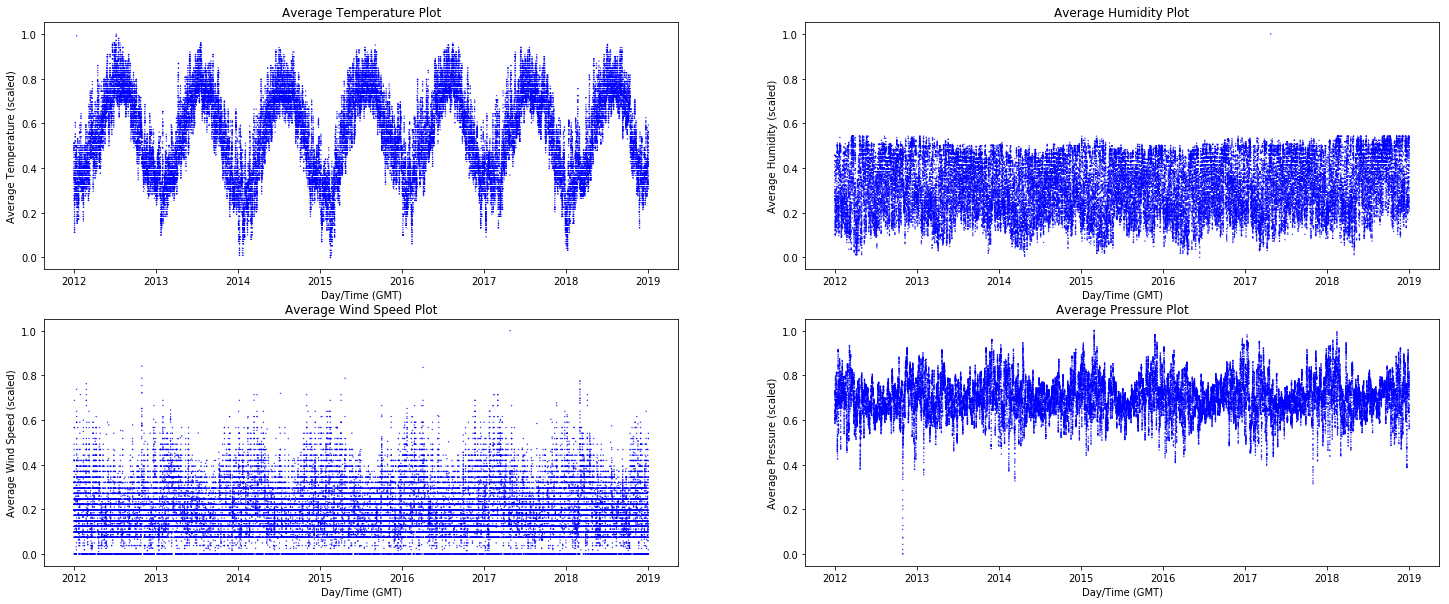

In [13]:
eda_plots(df_kphl_useful, 'b')

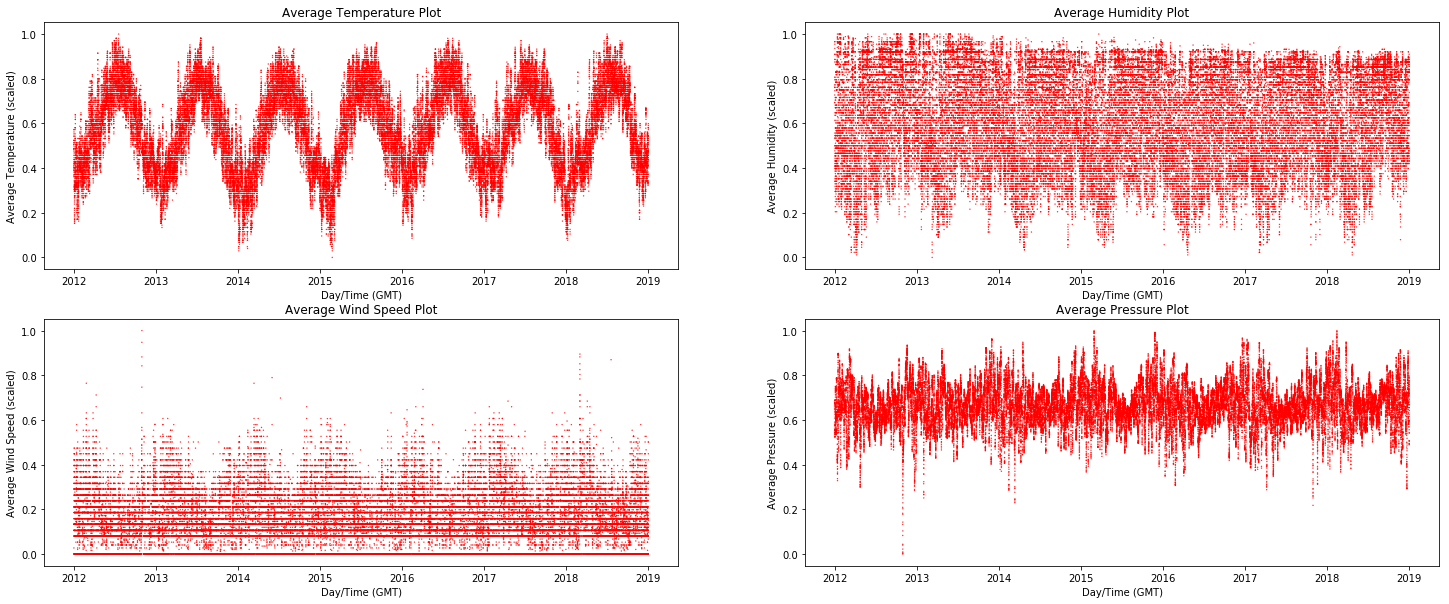

In [14]:
eda_plots(df_kabe_useful, 'r')

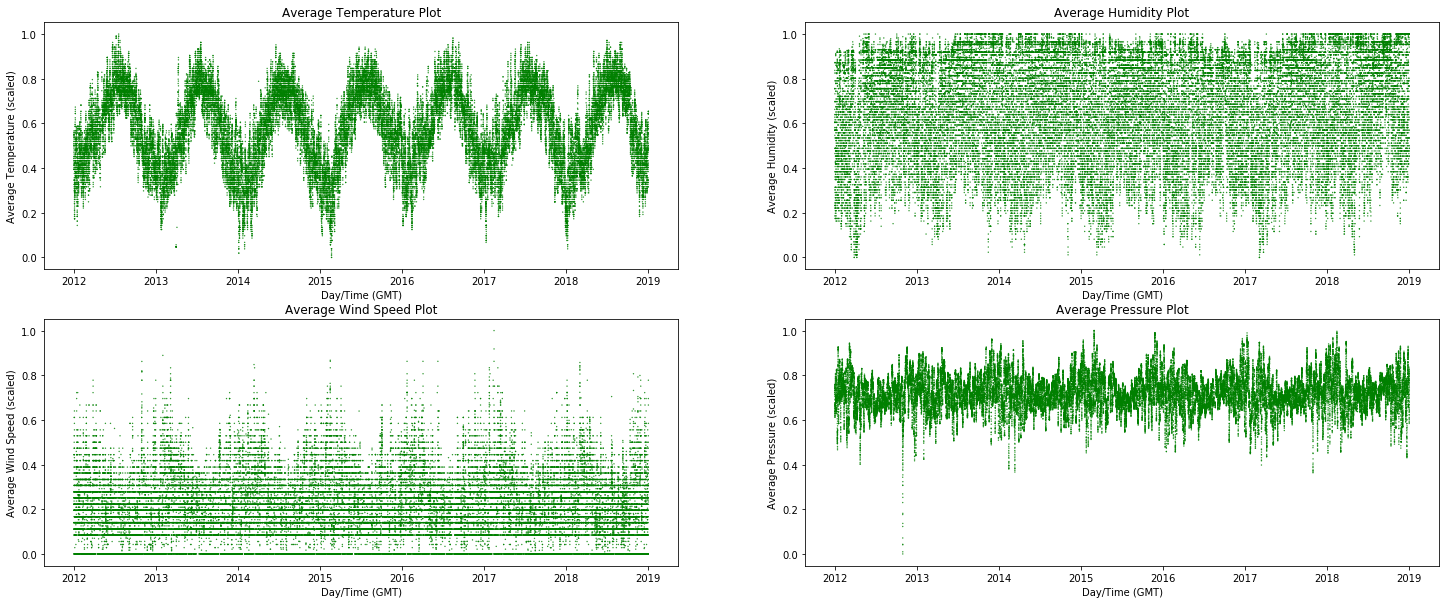

In [15]:
eda_plots(df_kacy_useful, 'g')

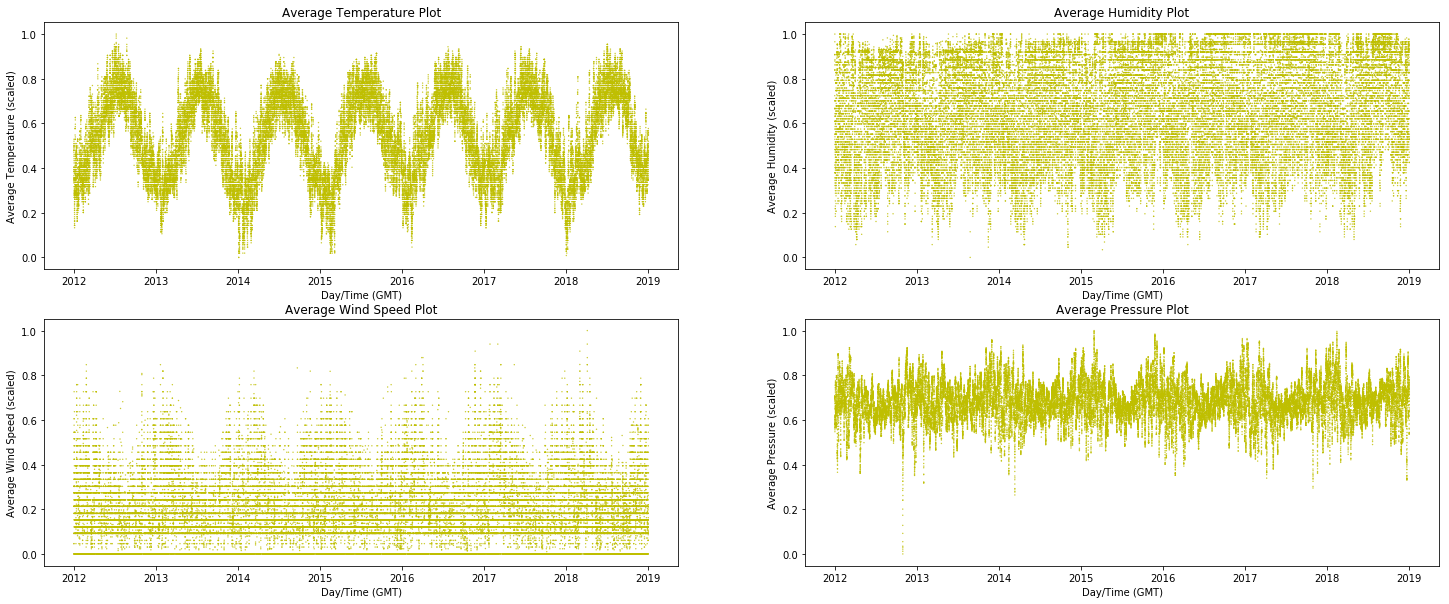

In [16]:
eda_plots(df_klns_useful, 'y')

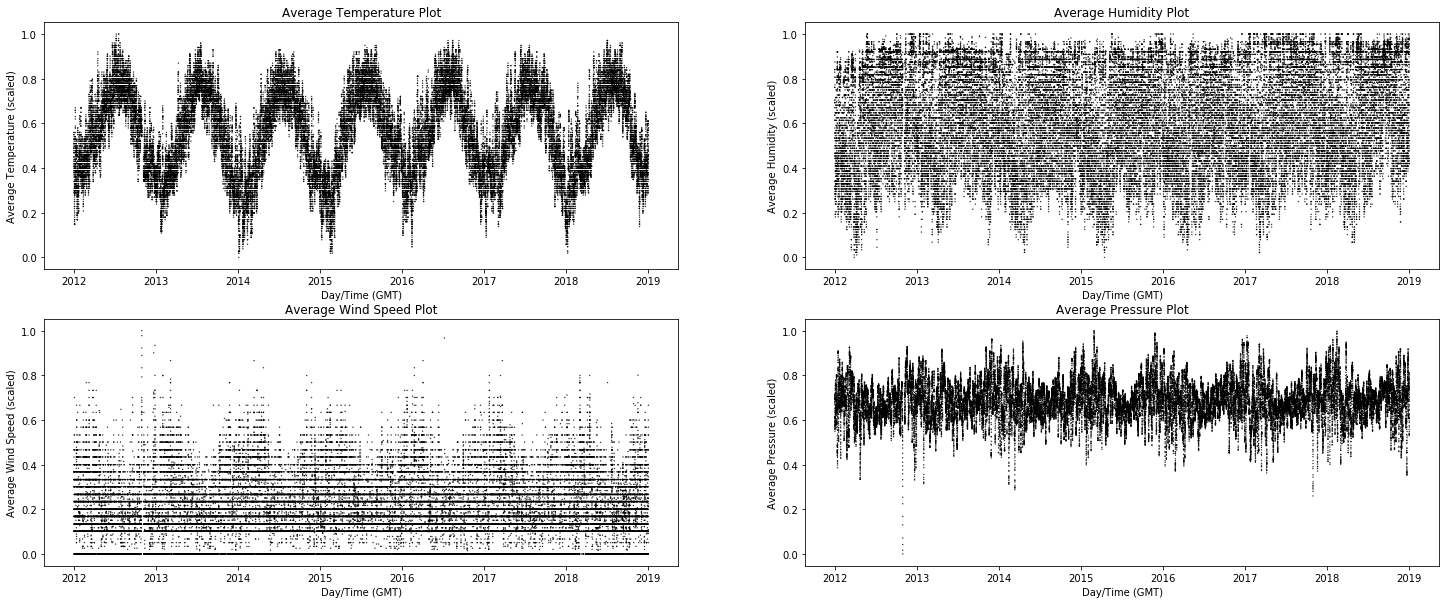

In [17]:
eda_plots(df_kttn_useful, 'k')

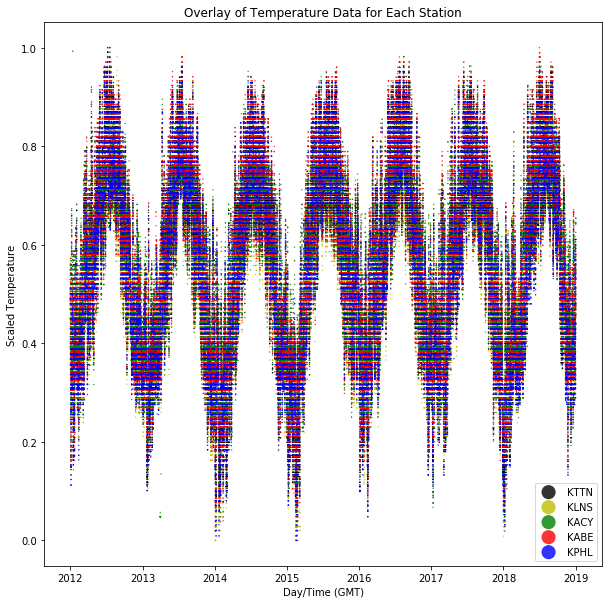

In [18]:
temp_data_1 = df_kttn_useful[df_kttn_useful.columns[0]]
temp_data_2 = df_klns_useful[df_klns_useful.columns[0]]
temp_data_3 = df_kacy_useful[df_kacy_useful.columns[0]]
temp_data_4 = df_kabe_useful[df_kabe_useful.columns[0]]
temp_data_5 = df_kphl_useful[df_kphl_useful.columns[0]]

plt.figure(figsize=(10,10))
plt.title("Overlay of Temperature Data for Each Station")

plt.scatter(df_kttn_useful.index, temp_data_1, alpha = 0.8, color='k', edgecolors='none', s=2)
plt.scatter(df_klns_useful.index, temp_data_2, alpha = 0.8, color='y', edgecolors='none', s=2)
plt.scatter(df_kacy_useful.index, temp_data_3, alpha = 0.8, color='g', edgecolors='none', s=2)
plt.scatter(df_kabe_useful.index, temp_data_4, alpha = 0.8, color='r', edgecolors='none', s=2)
plt.scatter(df_kphl_useful.index, temp_data_5, alpha = 0.8, color='b', edgecolors='none', s=2)

plt.ylabel("Scaled Temperature")
plt.xlabel("Day/Time (GMT)")
plt.legend(labels=['KTTN', 'KLNS', 'KACY', 'KABE', 'KPHL'], markerscale=10)

plt.show()

# Reindex all stations data 

In [26]:
start = df_kphl_useful.index[0]
end = df_kphl_useful.index[-1]
idx = pd.date_range(start, end, freq='H')

df_kphl_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_kabe_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_kttn_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_klns_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_kacy_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)

In [27]:
print("Start day is {}".format(df_kphl_useful.index[0]))
print("End day is {}".format(df_kphl_useful.index[-1]))

Start day is 2012-01-01 00:00:00
End day is 2019-01-01 23:00:00


# Use Random forest model to decide how big the window size should be to predict the temperature of the next hour

In [29]:
 # split into train and test sets (67% of them are for train data)
dataset = np.array(df_kphl_useful)

dataset = np.nan_to_num(dataset)
train, test = dataset[0:(1713*30),:], dataset[(1713*30):len(dataset),:]
print(len(train), len(test))

51390 10002


For now, we only use temperature data (use create_datasettemp function)

In [30]:
#Get Only temperature data
def create_datasettemp(dataset, look_back=25):
    data = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0].flatten()
        data.append(a)
    return np.array(data)

#Get all four variables
def create_dataset(dataset, look_back=24):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :].flatten()
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [39]:
#Tt=f(Tt−1,Tt−2,…..Tt−n,Pt−1,Pt−2,…..Pt−n,Ht−1,Ht−2,…..Ht−n,Wt−1,Wt−3,…..Wt−n)(3)

#train X will have 41087 sets of windows and each window has 96 variables (24*4)
#train Y will have 41087 sets of windoes and one variable for each time (temperature)

# reshape into X=t and Y=t+1
look_back = 10
traindata = create_datasettemp(train, look_back)
testdata = create_datasettemp(test, look_back)


traindata.shape

(51379, 10)

In [40]:
trainX = traindata[:,0:-1]
trainY = traindata[:,-1]

testX = testdata[:,0:-1]
testY = testdata[:,-1]

In [41]:
model.fit(trainX, trainY)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [42]:
print(model.feature_importances_)

[0.00872396 0.0063323  0.00613564 0.00617316 0.00676804 0.00675507
 0.00807715 0.05875539 0.89227929]


In [43]:
names = []
for i in range(look_back-1):
    names.append("t{}".format(i-look_back+1))
ticks = [i for i in range(len(names))]

In [44]:
from matplotlib import pyplot

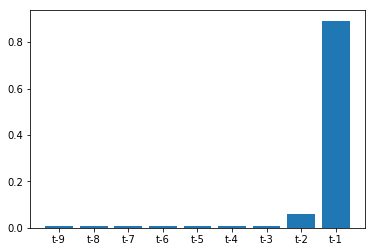

In [45]:
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

# We conclude that the 95% of next hour temperature can be predicted with previous two hours 
# Thus, we will use 2-4 (hours) window size when we design the model